In [154]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [155]:
# loading data
data = pd.read_csv(
    "/Users/yamadaikuya/Desktop/Research/Codes/csv/interactions.csv",
    )

In [156]:
data = data.dropna(subset=['Age', 'female', 'Years_of_Schooling', 'Math_Score',
       'parents_are_farmers', 'born_in_this_village', 'Risk_averse',
       'Competitive', 'Absolute_Overconfidence', 'Relative_Overconfidence', "Cut_Flower"])

In [157]:
data = data.drop(['type_', 'ln_workers_income_bf', 'ln_workers_income_cu',
       'save_rate'], axis=1)

In [158]:
# dataframe -> numpy.array
Y = data.loc[:, ["Cut_Flower"]].values
X = data.drop(["Cut_Flower"], axis=1).values
print(X.shape, Y.shape)
print(type(X))

(289, 55) (289, 1)
<class 'numpy.ndarray'>


In [159]:
def sigmoid(z):
    x = tf.placeholder(tf.float32, name="x")
    sigmoid = tf.sigmoid(x)
    sess = tf.Session()
    result = sess.run(sigmoid, feed_dict={x: z})
    sess.close()
    return result

In [160]:
def cost(logits, labels):
    z = tf.placeholder(tf.float32, name="z")
    y = tf.placeholder(tf.float32, name="y")
    cost = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=z)
    sess = tf.Session()
    cost = sess.run(cost, feed_dict={y: labels, z: logits})
    sess.close()
    return cost

In [161]:
logits = sigmoid(np.array([0.2, 0.4, 0.7, 0.9]))
cost = cost(logits, np.array([0,0,1,1]))
print("cost =" + str(cost))

cost =[1.0053872  1.0366409  0.41385433 0.39956614]


In [162]:
# n_x, n_y = nbr of variables
def create_placeholders(n_x, n_y):
    X = tf.placeholder(dtype=tf.float32, shape=[n_x, None])
    Y = tf.placeholder(dtype=tf.float32, shape=[n_y, None])
    return X, Y

In [198]:
# Initializing the parameters 
# Determin the shape of hidden layers
def initialize_parameters():
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [32, 55], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [32, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [16, 32], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [16, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1, 16], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [1, 1], initializer=tf.zeros_initializer())
    
    parameters={
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }
    
    return parameters

In [199]:
def forward_propagation(X, parameters):
    # retrieve parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)                   
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

In [200]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost

In [201]:
# check the behavior
tf.reset_default_graph()
sess = tf.Session()
a, b = create_placeholders(55, 1)
parameters = initialize_parameters()
Z3 = forward_propagation(a, parameters)
cost = compute_cost(Z3, b)
print("Z2 = {}".format(str(Z3)))
print("cost = {}".format(str(cost)))

Z2 = Tensor("Add_2:0", shape=(1, ?), dtype=float32)
cost = Tensor("Mean:0", shape=(), dtype=float32)


In [202]:
# Divide dataset 
X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size = 0.33, random_state = 1
)

In [203]:
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

In [204]:
print(X_train.shape)
print(Y_train.shape)

(55, 193)
(1, 193)


In [214]:
def model(X_train, Y_train, X_test, Y_test, num_epochs, learning_rate = 0.001,
         minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()  # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    
    for epoch in range(num_epochs+1):
        
        _, c = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
        
        epoch_cost = c
        
        if epoch % 1000 == 0:
            print("Cost after epoch %i: %f"%(epoch, epoch_cost))
        if epoch % 5 == 0:
            costs.append(epoch_cost)
    
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    # lets save the parameters in a variable
    print(type(parameters))
    parameters = sess.run(parameters)
    print ("Parameters have been trained!")

    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.round(tf.sigmoid(Z3)), Y)

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    #print(sess.run(tf.round(tf.sigmoid(Z2)), {X: X_train}))
    print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}, session=sess))
    print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}, session=sess))

    return parameters

In [174]:
s = tf.Session()
a = [0.501, 0.6,0.1]
b = [0, 1,1]
acc = tf.reduce_mean(tf.cast(tf.equal(tf.round(a), b),"float"))
print(s.run(acc))

0.33333334


Cost after epoch 0: 17.021378
Cost after epoch 1000: 9.664356
Cost after epoch 2000: 2.808422
Cost after epoch 3000: 0.912572
Cost after epoch 4000: 0.374888
Cost after epoch 5000: 0.193485
Cost after epoch 6000: 0.119534
Cost after epoch 7000: 0.084123
Cost after epoch 8000: 0.062196
Cost after epoch 9000: 0.046706
Cost after epoch 10000: 0.034830


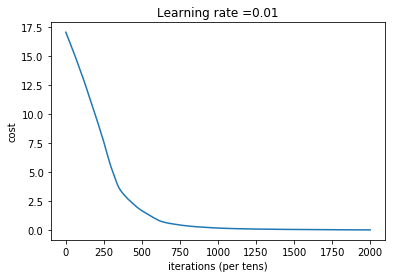

<class 'dict'>
Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.5416667


In [215]:
parameters = model(X_train, Y_train, X_test, Y_test, num_epochs=10000, learning_rate=0.01)